# Lab One: Visualization and Data Preprocessing

## Business Understanding

DonorsChoose.org is a crowd-funding website designed for teachers, by teachers. The current state of public school funding often leaves teachers to pay for supplies for projects that are beyond their available budget. In 2000, public school teachers in the Bronx launched DonorsChoose, and it has since spread to be available to all public schools in the United States. 

Teachers who work full-time in a public school in the US are eligible to submit a project. DonorsChoose then screens and posts the project to the site in a few days. Projects can remain on the site for up to four months. Donors contribute funds toward the projects they are interested in, and when the project is fully funded, DonorsChoose purchases the materials and sends it to the teacher. 

The dataset that we are working with was collected and shared on Kaggle by DonorsChoose.org. Because each project is screened before being posted, and the number of requests is expected to be large in coming years, the organization wants to find ways to pre-screen project requests. In doing so, the goal is to be able to auto-approve some requests, which will allow volunteers to focus their time on more complicated project requests. With this data, we will be working to determine which features are most predictive of approval. 

This is a classification problem, looking to predict whether a project submission is approved or not. To evaluate our predictive model effectiveness, we'll look at the are under the ROC, and we will use cross-fold validation for building and testing our model. Because the purpose of this model is to shift work/attention to project submissions that need additional assistance, a relatively low improvement over random would be considered useful. 

## Data Meaning Type

The dataset is broken into two files: the project information, contained in the test and train files, and the resources data, contained in the resources file. These two files can be joined based on ID to get the resources attributed to the project overal information. 

The project information contains information about the projects and the teachers/classrooms. This includes identification data, demographic data about the classroom and teacher, and information about the project itself. Details about the data in this file are as follows: 

| attribute | description | data type | scale/values |
| :-------- | :---------- | :-------: | :----------: |
| id | unique id for each project request | | unique values |
| teacher id | unique id for each teacher making a request | | repeated values when teacher submits multiple projects |
| teacher_prefix | title abbreviation the teacher uses | char | 'Ms.', 'Mrs.', 'Mr.', 'Teacher', 'Dr.' |
| school_state | two letter code of state where school is located | char(2) | 51 values: 50 states + DC |
| project_submitted_datetime | timestamp of application submission | datetime | The earliest submission was 2016-04-27 00:03:38.<br>The latest submission was 2017-04-30 23:50:43. |
| project_grade_category | indicates the school level of the classroom project | categorical, single-selected | 'Grades PreK-2'<br>'Grades 3-5'<br>'Grades 6-8'<br>'Grades 9-12'|
| project_subject_categories | high-level subject of the project | categorical, multi-selected | 'Literacy & Language'<br>'Math & Science'<br>'Applied Learning'<br>'Health & Sports'<br>'Special Needs'<br>'History & Civics'<br>'Music & The Arts'<br>'Warmth, Care & Hunger' |
| project_subject_subcategories | lower-level subject category | categorical, multi-selected | 29 subcategories |
| project title | title given to the project | text | length ranges from 4 to 141 characters |
| project_resource_summary | text summary of the resources that are being requested | text | length ranges from 25 to 908 characters |
| teacher_number_of_previously_posted_projects | shows how many projects the teacher has previously posted | numeric | 0-451 |
| project_is_approved | whether the project was approved or not by DonorsChoose | binary | '0'=rejected, '1'=accepted |

In addition to the featuers above, each submission contains 2 or 4 essay responses. For projects submitted before May 17, 2016, four essay questions were asked:
* project_essay_1: "Introduce us to your classroom"
* project_essay_2: "Tell us more about your students"
* project_essay_3: "Describe how your students will use the materials you're requesting"
* project_essay_4: "Close by sharing why your project will make a difference"

After May 17, 2016, only two essay questions were asked: 
* project_essay_1: "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."
* project_essay_2: "About your project: How will these materials make a difference in your students' learning and improve their school lives?"

In our analysis, we will need to account for these differences by submission date to ensure that we are comparing comparable questions.

The resources file includes only a few attributes about the resources that are being requested for the project. This is a separate file because projects can request multiple types of resources. We will join this resources data with the project information to get totals information about the number of resources and the total cost for a projects. 

| attribute | description | data type | scale/values |
| :-------- | :---------- | :-------: | ------------ |
| id | unique id for each project request | varchar | foreign key to the project information files |
| description | description of the resource being requested | text | |
| quantity | the number of this resource being requested | numeric | 1 - 800 | 
| price | the price per unit of the resources | numeric | 0 - 9999.00 |

In [1]:
##SOURCE: https://github.com/kaggle/kaggle-api
#Run the following command to access the Kaggle API using the command line: pip install kaggle
#go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and select 'Create API Token'
#This will trigger the download of kaggle.json, a file containing your API credentials. 
#Place this file in the location ~/.kaggle/kaggle.json 
    #(on Windows in the location C:\Users\<Windows-username>\.kaggle\kaggle.json).
#Run the following using the command line: kaggle competitions download -c donorschoose-application-screening
    #if you get an access denied warning you need to go to https://www.kaggle.com/c/donorschoose-application-screening/data
        #then click download for any zip file and click on 'accept rules' popup
            #you can now run the api download
#this will save to C:\Users\<Windows-username>\.kaggle\competitions\donorschoose-application-screening
#upload the csvs to your Jupyter 'data' file

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
df_train = pd.read_csv('train.csv')
df_train.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1


In [3]:
df_resources = pd.read_csv('resources.csv')
df_resources.head()

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [4]:
#https://www.kaggle.com/codename007/a-very-extensive-end-to-end-project-donorschoose
## Merging with train and test data ##
train_resource = pd.merge(df_train, df_resources, on="id", how='left')

In [5]:
print("Size of training data : ",df_train.shape)
print("Size of resource data : ",df_resources.shape)
print("Size of train_resource data : ",train_resource.shape)

Size of training data :  (182080, 16)
Size of resource data :  (1541272, 4)
Size of train_resource data :  (1081830, 19)


## Data Quality

In [6]:
print('The number of missing values in the main data frame: ', np.sum(df_train.isnull()))

The number of missing values in the main data frame:  id                                                   0
teacher_id                                           0
teacher_prefix                                       4
school_state                                         0
project_submitted_datetime                           0
project_grade_category                               0
project_subject_categories                           0
project_subject_subcategories                        0
project_title                                        0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 175706
project_essay_4                                 175706
project_resource_summary                             0
teacher_number_of_previously_posted_projects         0
project_is_approved                                  0
dtype: int64


We see that a vast majority of the columns do not have missing values. There are 4 missing data points in the teacher_prefix column. This houses data on the teacher's preferred prefix. We would like to look at whether or not there are other problems with these entries, for the sake of completeness. A majority of our rows are missing project essays 3 and 4; that will be discussed after the missing teacher prefixes are examined. 

In [7]:
df_train[df_train.teacher_prefix.isnull()]

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
17809,p180947,834f75f1b5e24bd10abe9c3dbf7ba12f,NaN,CA,2016-11-04 00:15:45,Grades 3-5,"Literacy & Language, Math & Science","Literature & Writing, Mathematics",1:7 Increasing Tech to Decrease Achievement Gaps,The children at Anna Yates Elementary school a...,My goal is to bring in 1 laptop for every 7 st...,NaN,NaN,My students need a classroom laptop that is ju...,1,1
22174,p002730,339bd5a9e445d68a74d65b99cd325397,NaN,SC,2016-05-09 09:38:40,Grades 9-12,Literacy & Language,Literature & Writing,iPads for STEM Stations,"Within the next 20 years, every job will invol...",The students in our school come from a wide va...,Students will use the iPad station for individ...,Your generosity will allow my students to work...,My students need 5 iPads for STEM stations.,0,1
127966,p153408,339bd5a9e445d68a74d65b99cd325397,NaN,SC,2016-05-10 15:18:23,Grades 9-12,Literacy & Language,Literature & Writing,iPad for STEM and Literacy Station,"Within the next 20 years, every job will invol...",The students in our school come from a wide va...,Students will use the iPad at the iPad station...,Your generosity will allow my students to work...,My students need 5 iPads with protection plans...,1,1
158692,p197901,e4be6aaaa887d4202df2b647fbfc82bb,NaN,PA,2016-06-03 10:15:05,Grades 3-5,"Literacy & Language, Math & Science","Literacy, Mathematics",Document Camera,Students at Robertsdale Elementary live in a l...,This SMART Document Camera will improve my stu...,NaN,NaN,My students need a Smart Document Camera to en...,0,1


As we can see, these entries are otherwise complete. The fact that it is missing is not concerning: it is likely that the teacher did not wish to identify their gender when completing the application, or they simply forgot to input a value. These missing values are therefore not a large concern for our data analysis, and these rows will be left untouched.

There are also roughly 176,000 rows that do not have the third and fourth project essays. This is because on May 17, 2016, DonorsChoose.org reduced the number of required essays from four to two. Therefore, it is realistic to believe that entries with all four essays were submitted before this date, and entries with only two essays were submitted after this date. The missing data is therefore not a call for concern. 

We also would like to check for missing values in the resource request dataset.

In [8]:
print('The number of missing values in the resource request dataset: ', np.sum(train_resource.isnull()))

The number of missing values in the resource request dataset:  id                                                    0
teacher_id                                            0
teacher_prefix                                       11
school_state                                          0
project_submitted_datetime                            0
project_grade_category                                0
project_subject_categories                            0
project_subject_subcategories                         0
project_title                                         0
project_essay_1                                       0
project_essay_2                                       0
project_essay_3                                 1043673
project_essay_4                                 1043673
project_resource_summary                              0
teacher_number_of_previously_posted_projects          0
project_is_approved                                   0
description                              

Once again, we see that some requests for items are missing teacher prefixes and the third and fourth project essays. As discussed before, the fact that these are missing are not a big concern to us.

What might be concerning is the missing descriptions.

In [9]:
train_resource[train_resource.description.isnull()].head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,description,quantity,price
4024,p024765,0c0df47224ad114b5c41cb801f0852e1,Mrs.,AR,2016-10-11 21:08:06,Grades 6-8,Applied Learning,"Character Education, Extracurricular",Crafting Cultural Acceptance,Our school serves a large rural area with over...,These crafting supplies will help bring to lif...,NaN,NaN,My students need craft supplies to bring to li...,0,0,NaN,1,9.95
23171,p154785,6e0e96a0225526789ae750eff06491c9,Mrs.,AR,2016-11-17 17:26:08,Grades PreK-2,Math & Science,"Applied Sciences, Mathematics",Hands on Learning Activities,My classroom family includes 19 excited and dr...,With these materials I will be able to create ...,NaN,NaN,My students need more hands on materials to pr...,0,1,NaN,1,9.95
25584,p180414,b62e6f4c3ffa9941328b071dfb7c3207,Mrs.,GA,2016-10-26 19:30:22,Grades 3-5,"History & Civics, Music & The Arts","History & Geography, Visual Arts",New Media Mania,Our students appreciate a smile and encouragem...,We are asking for some new materials for our A...,NaN,NaN,My students need some to experiment with excit...,8,1,NaN,1,9.95
26445,p233362,81b426f793c5142f972ecaf89bbc168b,Mrs.,TX,2016-12-05 16:36:25,Grades 3-5,Music & The Arts,Visual Arts,Art Supplies,"My students are full of life, and are ready to...","I teach 1st-6th grade, and we are in desperate...",NaN,NaN,My students need are in desperate need of exci...,0,1,NaN,1,9.95
37565,p121762,0f94cea7872eaf2e005036314ce03240,Mrs.,NY,2016-11-01 20:34:41,Grades 6-8,Music & The Arts,"Performing Arts, Visual Arts",Craft Club Moves to Queens,"As I walk into the lunch room, I hear students...",Our after school craft club has great ambition...,NaN,NaN,"My students need cloth canvases, crayons, tie-...",6,0,NaN,1,9.95


Item requests that are missing descriptions are otherwise complete. Comparing the items listed in the resource summary to the quantities and prices requested, this once again seems to be a case of a teacher forgetting to put in a description. It is also important to note that these projects are able to get approved without these descriptions. Because they are able to get approved, the lack of description must be acceptable to DonorsChoose. We will therefore leave the rows without descriptions in the dataset. There is no good way to impute these values, so they will be left as they are. 

In [10]:
print('Number of duplicate rows in main data frame: ', sum(df_train.duplicated()))
print("Number of duplicate rows in the teacher's request data frame: ", sum(train_resource.duplicated()))

Number of duplicate rows in main data frame:  0
Number of duplicate rows in the teacher's request data frame:  8576


We see that there is a large number of repeated rows in the resource request dataset, and none in the project dataset. This is too many rows to practically go through by hand, so we will instead look at the first 5 rows to get an idea of what these repeated rows look like. 

In [11]:
train_resource[train_resource.duplicated()].head(5)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,description,quantity,price
148,p000139,f68fedcb0852d8a6ce88f7b4139b9227,Mr.,TX,2016-08-07 20:33:16,Grades 9-12,Music & The Arts,Music,Deeds for Reeds,"As I've written here before, we work to use ba...",A guitar can't sound good with broken or worn ...,NaN,NaN,My students need access to quality replacement...,3,1,Tenor Saxophone Reeds,1,20.95
153,p000139,f68fedcb0852d8a6ce88f7b4139b9227,Mr.,TX,2016-08-07 20:33:16,Grades 9-12,Music & The Arts,Music,Deeds for Reeds,"As I've written here before, we work to use ba...",A guitar can't sound good with broken or worn ...,NaN,NaN,My students need access to quality replacement...,3,1,Traditional Bb Clarinet Reeds,6,21.95
394,p160114,d523f258b55bb41c3bcb6dd67cfab6c1,Ms.,OK,2016-09-22 01:14:50,Grades PreK-2,"Literacy & Language, Special Needs","Literacy, Special Needs",Bring Our Story to Life,"The students at my school are multicultural, c...",My students struggle with writing. Sometimes ...,NaN,NaN,"My students need a printer, ink and paper. Th...",0,1,Brother LC109BK - Super High Yield - black - o...,1,32.70
469,p192882,d36c158f9f95db287dc019fe6f00cdad,Mrs.,WI,2016-08-20 11:27:08,Grades PreK-2,Health & Sports,Health & Wellness,Learn and Move,As a teacher in a low-income/high poverty scho...,This past year I noticed how wiggly my student...,NaN,NaN,"My students need Hokk chairsi, wobble chairs a...",0,0,Norwood Commercial Furniture NOR-STOOLBS-SO Pl...,1,48.95
740,p240306,1ee0a12eeb5da1c2fb438c682c8177dc,Mrs.,GA,2017-03-02 16:57:41,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Create - Evaluate - Celebrate,CREATE - EVALUATE - CELEBRATE!!!!\r\nEach chil...,Osmo states that it enables the iPad to merge ...,NaN,NaN,My students need to be challenged using techno...,2,1,Osmo Starter Kit,1,79.99


We see a large variety of items being repeated. Looking at the resource summaries for these requests indicates that many of these teachers are looking for sets of certain items. Many of these rows have quantities of 1 listed. Because teachers work in classrooms with many students that are forced to share supplies, it is plausible that the teacher intentionally created requests for the same item multiple times, instead of requesting a high quantity of a single item. 

This could be because the teacher initially requested one item, reevaluated her class's needs, and just requested the same item again. Or a teacher may not understand how to request multiple copies of the same item, and instead requests multiple singletons. 

A few of these listings are for requests of quantities greater than 1. These seem to be for class sets of items, perhaps with the goal of providing an item for each student or for every other student. In this case, it is still reasonable to believe the duplicate requests were genuine.

It's also important to note that these projects are also getting approved. The evaluation done by DonorsChoose does not immediately disqualify repeating items on the list. This makes sense with the structure around how DonorsChoose fulfills requests. When a teacher is approved, if they recieve the required donations, the money goes to DonorsChoose. DC then orders the supplies and ships them directly to the school; requesting multiple items is in no way a cash grab for the teachers. 

Because teacher requests can contain multiple distinct items, we will need to find the total quantity requested for each item, not just the total number of items requested for the project. 

In [12]:
t2 = train_resource.pivot_table(index = ['id', 'description'],
                                values='quantity', 
                                aggfunc=np.sum)
t2.reset_index(inplace=True)
train_resource = pd.merge(train_resource,
                          t2, 
                          on=['id', 'description'], 
                          how='right',
                          suffixes=('_Orig', '_True'))
train_resource[train_resource.duplicated()].head(5)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,description,quantity_Orig,price,quantity_True
148,p000139,f68fedcb0852d8a6ce88f7b4139b9227,Mr.,TX,2016-08-07 20:33:16,Grades 9-12,Music & The Arts,Music,Deeds for Reeds,"As I've written here before, we work to use ba...",A guitar can't sound good with broken or worn ...,NaN,NaN,My students need access to quality replacement...,3,1,Tenor Saxophone Reeds,1,20.95,2
153,p000139,f68fedcb0852d8a6ce88f7b4139b9227,Mr.,TX,2016-08-07 20:33:16,Grades 9-12,Music & The Arts,Music,Deeds for Reeds,"As I've written here before, we work to use ba...",A guitar can't sound good with broken or worn ...,NaN,NaN,My students need access to quality replacement...,3,1,Traditional Bb Clarinet Reeds,6,21.95,16
394,p160114,d523f258b55bb41c3bcb6dd67cfab6c1,Ms.,OK,2016-09-22 01:14:50,Grades PreK-2,"Literacy & Language, Special Needs","Literacy, Special Needs",Bring Our Story to Life,"The students at my school are multicultural, c...",My students struggle with writing. Sometimes ...,NaN,NaN,"My students need a printer, ink and paper. Th...",0,1,Brother LC109BK - Super High Yield - black - o...,1,32.70,2
469,p192882,d36c158f9f95db287dc019fe6f00cdad,Mrs.,WI,2016-08-20 11:27:08,Grades PreK-2,Health & Sports,Health & Wellness,Learn and Move,As a teacher in a low-income/high poverty scho...,This past year I noticed how wiggly my student...,NaN,NaN,"My students need Hokk chairsi, wobble chairs a...",0,0,Norwood Commercial Furniture NOR-STOOLBS-SO Pl...,1,48.95,2
740,p240306,1ee0a12eeb5da1c2fb438c682c8177dc,Mrs.,GA,2017-03-02 16:57:41,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Create - Evaluate - Celebrate,CREATE - EVALUATE - CELEBRATE!!!!\r\nEach chil...,Osmo states that it enables the iPad to merge ...,NaN,NaN,My students need to be challenged using techno...,2,1,Osmo Starter Kit,1,79.99,2


Excellent! We now know the true quantity of every item requested in the quantity_True column. We can therefore drop duplicates and calculate the total cost for each item. With that information, we can then find the total cost of each project and other statistics.

In [13]:
train_resource = train_resource.drop_duplicates()
train_resource = train_resource.drop('quantity_Orig', axis=1)
train_resource = train_resource.rename(columns={'quantity_True': 'True_Quantity'})
train_resource['Total_Cost'] = train_resource.price * train_resource.True_Quantity
print("Number of duplicate rows in the teacher's request data frame: ", sum(train_resource.duplicated()))

Number of duplicate rows in the teacher's request data frame:  2672


We have now eliminated all duplicate rows! We also want to find the total cost of every project.

In [14]:
Total_cost = train_resource.pivot_table(values=['Total_Cost','True_Quantity'],
                                        index='id',
                                        aggfunc={'Total_Cost' : np.sum, 'True_Quantity' : np.sum})
Total_cost.reset_index(level=0, inplace = True)

df_train = df_train.merge(Total_cost, on='id', how='left')
df_train['Average_item_cost'] = df_train.Total_Cost  / df_train.True_Quantity

In [15]:
df_train.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,Total_Cost,True_Quantity,Average_item_cost
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1,899.94,6.0,149.990
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0,400.00,20.0,20.000
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1,469.99,1.0,469.990
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0,684.47,5.0,136.894
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1,711.00,2.0,355.500


## Simple Statistics

The variable we are interested in predicting is whether the project is approved or not. This is represented as the binary variable "project_is_approved". We have a significant number more projects that get approved than don't, with a 84% approval rating, compared to a 16% rate for project submissions that do not get approved.

In [16]:
df_train["project_is_approved"].value_counts()

1    154346
0     27734
Name: project_is_approved, dtype: int64

In [17]:
df_train.describe()

,teacher_number_of_previously_posted_projects,project_is_approved,Total_Cost,True_Quantity,Average_item_cost
count,182080.000000,182080.000000,182077.000000,182077.000000,182077.000000
mean,11.237055,0.847682,553.089228,17.235274,117.880909
std,28.016086,0.359330,568.379819,27.047954,273.697523
min,0.000000,0.000000,73.680000,1.000000,0.258889
25%,0.000000,1.000000,247.330000,4.000000,17.027500
50%,2.000000,1.000000,398.800000,9.000000,45.926250
75%,9.000000,1.000000,697.810000,21.000000,135.760000
max,451.000000,1.000000,16319.360000,1404.000000,9999.000000


One thing of note is that the 75th percentile of almost every numerical column is drastically different from the maximum value. We have seen before that these values are likely legitimate, so we would now like to look at the distributions of these variables.

### Previously Posted Projects
From the table above, we see that the mean number of projects previously posted is 11, with a standard deviation of 28. This is evidence of a heavily skewed distribution, so we will start by looking at histograms of the distribution of number of previously posted projects for each teacher in the dataset.

Text(0,0.5,'Number of Teachers')

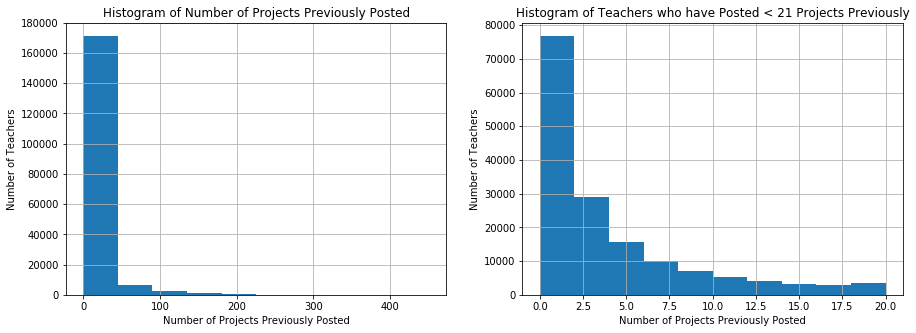

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Histogram of Number of Projects Previously Posted')
df_train.teacher_number_of_previously_posted_projects.hist()
plt.xlabel('Number of Projects Previously Posted')
plt.ylabel('Number of Teachers')
plt.subplot(1,2,2)
plt.title('Histogram of Teachers who have Posted < 21 Projects Previously')
df_train[df_train['teacher_number_of_previously_posted_projects'] < 21]['teacher_number_of_previously_posted_projects'].hist()
plt.xlabel('Number of Projects Previously Posted')
plt.ylabel('Number of Teachers')

Above is a histogram of the number of projects previously requested by number of teachers. We see the distribution is heavily left-skewed, with the vast majority of teachers having posted less than 100 projects. The histogram on the right indicates that many of these teachers have posted less than two projects. This makes sense, as DonorsChoose is a charity meant to supplement a teacher with supplies they may need. It is not intended to be a primary provider. This non-uniform distribution is important to keep in mind in the future when predicting project approval, as a teacher who has more experience posting projects will likely have proposals more properly tailored to getting approval than a first-time poster.

It also reveals a possibly worrying fact that some teachers are posting a lot of projects, perhaps excessively. This combined with the fact that the minimum total cost of a project is $73 implies that some teachers could potentially be getting thousands of dollars in support from this charity. This could be evidence of either underfunding of certain states or regions, or possible abuse of the charity if a teacher is so reliant on this funding. This however is a topic we are not examining in this analysis.

Text(0,0.5,'US Dollars')

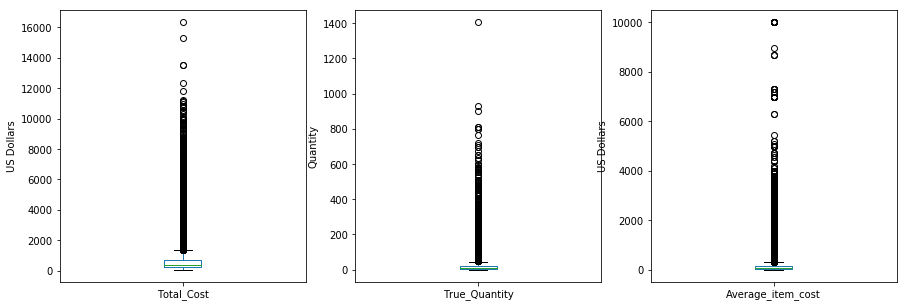

In [19]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
df_train.Total_Cost.plot(kind='box')
plt.ylabel('US Dollars')
plt.subplot(1,3,2)
df_train.True_Quantity.plot(kind='box')
plt.ylabel('Quantity')
plt.subplot(1,3,3)
df_train.Average_item_cost.plot(kind='box')
plt.ylabel('US Dollars')

These boxplots are quite revealing to the distributions of our variables. Much like the number of projects posted by teacher, it is heavily, heavily right-skewed. We will therefore have to be very cautious in the future when doing statistics, as our distributions are absolutely not normal (or any other common distribution.) It however also provides more evidence that these extreme values are not outliers, there are many extreme projects in the dataset.

### Project and Average Item Cost, by Project Approval


#### Approved Projects

In [20]:
approved = df_train[df_train.project_is_approved==1]
approved.describe()

,teacher_number_of_previously_posted_projects,project_is_approved,Total_Cost,True_Quantity,Average_item_cost
count,154346.000000,154346.0,154343.000000,154343.000000,154343.000000
mean,12.015867,1.0,545.618865,16.649540,123.688047
std,29.423888,0.0,566.936803,26.441873,283.736494
min,0.000000,1.0,73.680000,1.000000,0.258889
25%,0.000000,1.0,241.920000,3.000000,17.090000
50%,2.000000,1.0,394.180000,8.000000,49.867500
75%,9.000000,1.0,685.770000,20.000000,147.350000
max,451.000000,1.0,16319.360000,1404.000000,9999.000000


#### Non-approved Projects

In [21]:
unapproved = df_train[df_train.project_is_approved==0]
unapproved.describe()

,teacher_number_of_previously_posted_projects,project_is_approved,Total_Cost,True_Quantity,Average_item_cost
count,27734.000000,27734.0,27734.000000,27734.000000,27734.000000
mean,6.902791,0.0,594.662687,20.494952,85.563498
std,17.684081,0.0,574.583124,29.991746,206.245545
min,0.000000,0.0,100.000000,1.000000,0.396239
25%,0.000000,0.0,273.527500,6.000000,16.785767
50%,2.000000,0.0,429.950000,12.000000,34.631591
75%,6.000000,0.0,736.082500,24.000000,83.748750
max,379.000000,0.0,15299.690000,808.000000,9999.000000


In [22]:
from scipy.stats import ranksums
print('One-sided p-value of difference in total cost between approved and non-approved projects : ', 
      ranksums(df_train[df_train.project_is_approved==0].Total_Cost,
               df_train[df_train.project_is_approved==1].Total_Cost)[1])
print('One-sided p-value of difference in Quantity of Items between approved and non-approved projects : ',
      ranksums(df_train[df_train.project_is_approved==0].True_Quantity,
               df_train[df_train.project_is_approved==1].True_Quantity)[1])
print('One-sided p-value of difference in average item cost between approved and non-approved projects : ',
      ranksums(df_train[df_train.project_is_approved==0].Average_item_cost,
               df_train[df_train.project_is_approved==1].Average_item_cost)[1])

One-sided p-value of difference in total cost between approved and non-approved projects :  4.658405890215333e-100
One-sided p-value of difference in Quantity of Items between approved and non-approved projects :  0.0
One-sided p-value of difference in average item cost between approved and non-approved projects :  1.3052296816583515e-189


Looking at the difference in total cost of approved compared to unapproved projects, it seems that approved projects are generally lower cost than non-approved projects. The Rank-Sums test indicates this is the case with very high certainty (p-value < $10^{-100}$). The Rank-Sum test also found statistical evidence that the quantity of items is different between approved and non-approved projects as well. The Rank-Sum test also provides strong evidence that the average item cost is different for approved and non-approved groups, with a similarly high p-value (~$10^{-190}$). We can therefore estimate these quantities using our data. Approved projects typically cost about \$50 less than un-approved projects; request 4 items fewer; and request items that cost about \$40 more.

This immediately tells us that projects requesting a low number of more expensive items are more likely to be approved. It also provides preliminary evidence that total cost and average item cost are likely helpful predictors in the future.

project_is_approved        False     True 
project_grade_category                    
Grades 3-5              0.146023  0.853977
Grades 6-8              0.156541  0.843459
Grades 9-12             0.164764  0.835236
Grades PreK-2           0.152876  0.847124


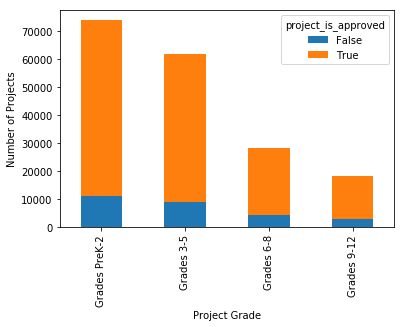

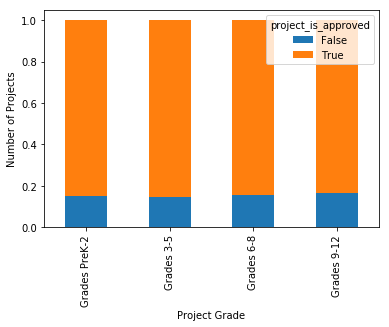

In [23]:
counts = pd.crosstab(df_train.project_grade_category, df_train.project_is_approved.astype(bool))
counts_prop = counts.div(counts.sum(1).astype(float),axis=0)
## https://stackoverflow.com/questions/47255746/change-order-on-x-axis-for-matplotlib-chart used
bar_order = ['Grades PreK-2', 'Grades 3-5', 'Grades 6-8', 'Grades 9-12']
counts.loc[bar_order].plot(kind='bar', stacked=True)
plt.ylabel('Number of Projects')
plt.xlabel('Project Grade')
counts_prop.loc[bar_order].plot(kind='bar',stacked=True)
plt.xlabel('Project Grade')
plt.ylabel('Number of Projects')

print(counts_prop)

Looking at this first graph, we can see that as students get older, the number of projects posted that are targetted towards them decreases. In fact, there are 3 times as many projects aimed at students between Pre-K and second grade than there are aimed at high schoolers. However, the bottom graph indicates that there is very little difference in the rate of the different grade levels' projects being approved. The rate of approval of is aroud 84-85% for all grade levels.

## Visualize Attributes

In this section we will visualize and interpret the most important attributes of the data set.  We will also explore relationships between attributes in order to gain insight into how the variables might help explain the response variable 'project_is_approved'.

In [24]:
#import dataset
import pandas as pd
import numpy as np
df_train = pd.read_csv('train.csv')
df_resources = pd.read_csv('resources.csv')
df_resources['Total_cost'] = df_resources.quantity * df_resources.price
train_resource = pd.merge(df_train, df_resources, on="id", how='left')
#https://www.kaggle.com/codename007/a-very-extensive-end-to-end-project-donorschoose
## Merging with train and test data ##
train_resource = pd.merge(df_train, df_resources, on="id", how='left')

Total_cost = train_resource.pivot_table(values=['Total_cost','quantity'],
                                        index='id',
                                        aggfunc={'Total_cost' : np.sum, 'quantity' : np.sum})
Total_cost.reset_index(level=0, inplace = True)

df_train = df_train.merge(Total_cost, on='id', how='left')
df_train['Average_item_cost'] = df_train.Total_cost  / df_train.quantity
df_train['proj_submitted_count'] = 1
date_features = ['project_submitted_datetime']
df_train[date_features] = df_train[date_features].astype('datetime64[ns]')
df_train['project_submitted_YM'] = df_train['project_submitted_datetime'].apply(lambda x: x.strftime('%Y%m'))
##df_train.info()

Before diving into the relationships let's get familiar with the response variable that we wish to predict, 'project_is_approved'

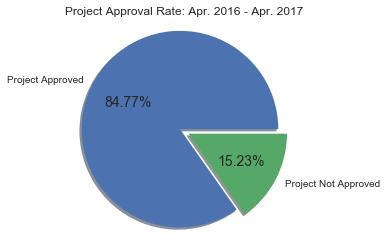

In [25]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

aprvd = float(len(df_train[df_train.project_is_approved != 0]))/len(df_train) * 100
Naprvd = float(len(df_train[df_train.project_is_approved== 0]))/len(df_train) * 100

##https://matplotlib.org/examples/pie_and_polar_charts/pie_demo_features.html
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Project Approved', 'Project Not Approved'
sizes = [aprvd, Naprvd]
#colors = ['xkcd:teal', 'xkcd:grey']
explode = (0.0,0.1)  
plt.rcParams['font.size'] = 14.0

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        shadow=True, startangle=360)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Project Approval Rate: Apr. 2016 - Apr. 2017')
plt.show()

The pie chart above looks at project approval rates across the entire time period of the dataset provided.  We see that the approval rate is high, with only 15% of project submissions declined.  

This suggests that the submission process was set-up only to weed out applications that were not applicable to the overall mission of DonorsChoose.org, and perhaps even to act as a filter to discourage fraudulent applications. 

Next we will look at the approval rate by the year and month of the application submission.

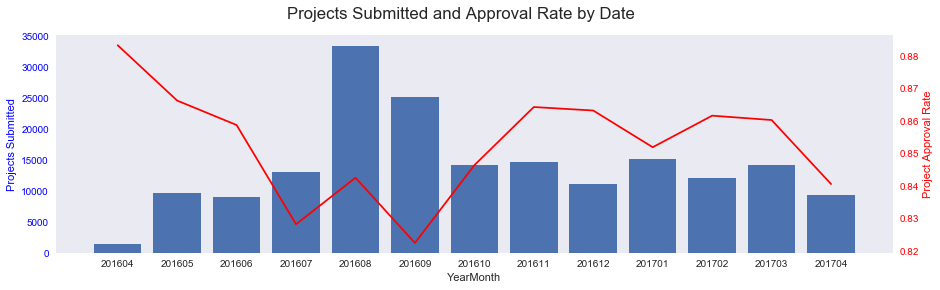

In [26]:
#https://stackoverflow.com/questions/32474434/trying-to-plot-a-line-plot-on-a-bar-plot-using-matplotlib
projSub = df_train.pivot_table(values=['proj_submitted_count','project_is_approved'],
                                        index='project_submitted_YM',
                                        aggfunc={'proj_submitted_count' : np.sum
                                               , 'project_is_approved' : np.sum})
projSub.reset_index(level=0, inplace = True)

projSub['proj_approval_rate'] = (projSub.project_is_approved/projSub.proj_submitted_count)
del projSub['project_is_approved']

date = projSub.project_submitted_YM  
projSubmitted = projSub.proj_submitted_count
projApprvdRate = projSub.proj_approval_rate

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()
fig.set_figwidth(15)
fig.suptitle('Projects Submitted and Approval Rate by Date')

#Plot bars
#projSubmitted.plot()
plt.bar(date,projSubmitted)
ax1.set_xlabel('YearMonth')
ax1.grid(False)

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Projects Submitted', color='b')
[tl.set_color('b') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
plt.plot(date,projApprvdRate, color = 'r')
ax2.grid(False)

# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Project Approval Rate', color='r')
[tl.set_color('r') for tl in ax2.get_yticklabels()]
plt.show()

The chart above shows how the approval rate fluctuated over the thirteen month time period.  The blue bars represent submission volume and the red line represents the approval rate within the same month.  The range of the approval rate axis is intentionally small in order to focus on the changes by month.  Note that the total range of approval rates is only 6% during the thirteen month period.

The submission volumes peaked in August and September, a time when most teachers are returning from summer break.  The dip in approval rates during this same time period may be caused be a lack of resources on the reviewers' side, i.e., they may become slightly more strict with the applications as a result of increased submission volume.  

Another possibility is that there is a lagged time component where the glut of new applications aren't fully reviewed and decisioned until one or two months after the applications were submitted.  Approval rates rose in October and November.  This may be due to the residual volume from August and September being processed. It may also be due to teachers getting to know their newest cohort of students, and having new ideas for how to teach this year's students most effectively.

Now we will turn our attention towards the state the school is located.

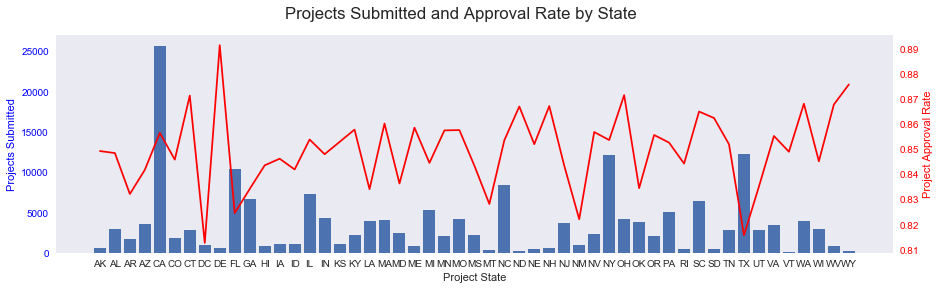

,school_state,proj_submitted_count,proj_approval_rate
8,DE,589,0.891341
50,WY,177,0.875706
35,OH,4139,0.871467
6,CT,2766,0.871294
47,WA,3903,0.868050


In [27]:
projState = df_train.pivot_table(values=['proj_submitted_count','project_is_approved'],
                                        index='school_state',
                                        aggfunc={'proj_submitted_count' : np.sum
                                               , 'project_is_approved' : np.sum})
projState.reset_index(level=0, inplace = True)

projState['proj_approval_rate'] = (projState.project_is_approved/projState.proj_submitted_count)
del projState['project_is_approved']

state = projState.school_state  
projSubmitted = projState.proj_submitted_count
projApprvdRate = projState.proj_approval_rate

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()
fig.set_figwidth(15)
fig.suptitle('Projects Submitted and Approval Rate by State')

#Plot bars
#projSubmitted.plot()
plt.bar(state,projSubmitted)
ax1.set_xlabel('Project State')
ax1.grid(False)

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Projects Submitted', color='b')
[tl.set_color('b') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
plt.plot(state,projApprvdRate, color = 'red')
ax2.grid(False)

# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Project Approval Rate', color='r')
[tl.set_color('r') for tl in ax2.get_yticklabels()]
plt.show()
#sort table
projState = projState.sort_values('proj_approval_rate',ascending=False)
projState.head()

In [28]:
projState.tail()

,school_state,proj_submitted_count,proj_approval_rate
26,MT,384,0.828125
9,FL,10359,0.824500
32,NM,916,0.822052
43,TX,12304,0.815670
7,DC,902,0.812639


The chart above shows project submission volume and approval rates by state. The two tables show the top five states by approval rate (top table) and the bottom five states by approval rate (bottom table). One overlay that may be very interesting for future analysis would be to try to determine the driver of the differences in approvals rates between the top and bottom five states. Is this difference purely random, or is it statistically significant? Demographic features from these states could potentially be useful in answering this question.

Let's now turn our attention to the quantities requested and see if that could cause a difference in approval rates.

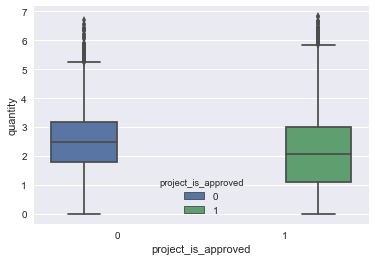

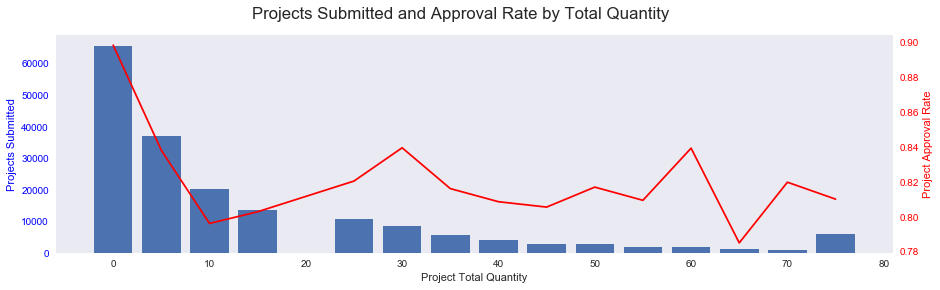

In [29]:
##boxplot quantity by is_approved
sns.boxplot(x="project_is_approved", 
            y=df_train["quantity"].apply(np.log),
            hue="project_is_approved",
 data=df_train)

##bar and line plot quantity by is_approved
df_train['total_quantity_group'] = pd.cut(df_train['quantity']
                                      , bins = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,1e6]
                                      , labels = [0,5,10,15,25,30,35,40,45,50,55,60,65,70,75])
df_train['total_quantity_group'] = df_train['total_quantity_group'].astype(np.int64)

projQuant = df_train.pivot_table(values=['proj_submitted_count','project_is_approved'],
                                        index='total_quantity_group',
                                        aggfunc={'proj_submitted_count' : np.sum
                                               , 'project_is_approved' : np.sum})
projQuant.reset_index(level=0, inplace = True)

projQuant['proj_approval_rate'] = (projQuant.project_is_approved/projQuant.proj_submitted_count)
del projQuant['project_is_approved']
quant = projQuant.total_quantity_group  
projSubmitted = projQuant.proj_submitted_count
projApprvdRate = projQuant.proj_approval_rate

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()
fig.set_figwidth(15)
fig.suptitle('Projects Submitted and Approval Rate by Total Quantity')

#Plot bars
plt.bar(quant,projSubmitted, width = 4)
ax1.set_xlabel('Project Total Quantity')
ax1.grid(False)

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Projects Submitted', color='b')
[tl.set_color('b') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
plt.plot(quant,projApprvdRate, color = 'red')
ax2.grid(False)

# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Project Approval Rate', color='r')
[tl.set_color('r') for tl in ax2.get_yticklabels()]
plt.show()

The chart directly above shows projects submitted and approval rates by the quantity of materials requested.  The box plot above the chart is a log transform of the quantity requested split between applications that were approved and not approved.

The box plot does not show a radical difference in terms of quantity requested between applications that were approved and applications that were not approved.  One difference, however, is the lower quartile range of approved applications.  This suggests that applications that request lower quanties have a better chance of being approved.  This is furthered by the chart where there does seem to be a negative correlation between increases in quantity and the likelyhood of an application being approved.  We will revisit the correlations and address them directly at the end of this section.

Next we will look at the same analysis as above, but for total cost instead of quantity.

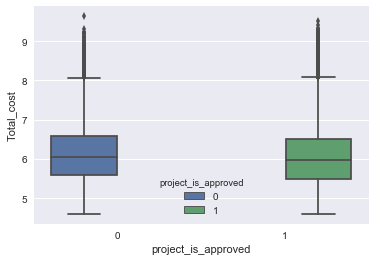

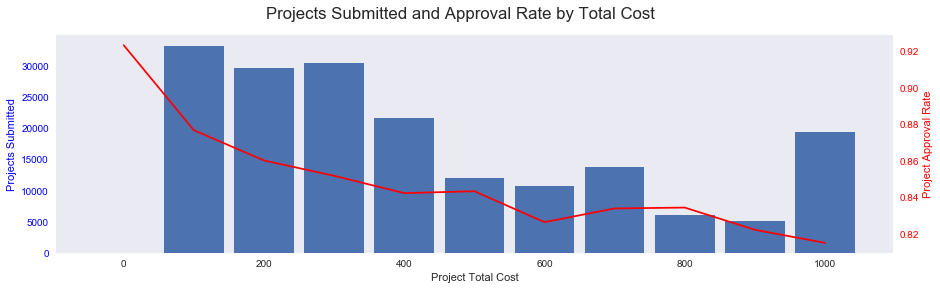

In [30]:
##boxplot total cost by is_approved
sns.boxplot(x="project_is_approved", 
            y=df_train["Total_cost"].apply(np.log),
            hue="project_is_approved",
 data=df_train)

df_train['total_cost_group'] = pd.cut(df_train['Total_cost']
                                      , bins = [0,100,200,300,400,500,600,700
                                                ,800,900,1000,1e6]
                                      ,labels = [0,100,200,300,400,500,600,700
                                                ,800,900,1000])
df_train['total_cost_group'] = df_train['total_cost_group'].astype(np.int64)

projCost = df_train.pivot_table(values=['proj_submitted_count','project_is_approved'],
                                        index='total_cost_group',
                                        aggfunc={'proj_submitted_count' : np.sum
                                               , 'project_is_approved' : np.sum})
projCost.reset_index(level=0, inplace = True)

projCost['proj_approval_rate'] = (projCost.project_is_approved/projCost.proj_submitted_count)
del projCost['project_is_approved']

cost = projCost.total_cost_group  
#print(state)
projSubmitted = projCost.proj_submitted_count
#print(projSubmitted)
projApprvdRate = projCost.proj_approval_rate
#print(projApprvdRate)

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()
fig.set_figwidth(15)
fig.suptitle('Projects Submitted and Approval Rate by Total Cost')

#Plot bars
#projSubmitted.plot()
plt.bar(cost,projSubmitted, width = 85)
ax1.set_xlabel('Project Total Cost')
ax1.grid(False)

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Projects Submitted', color='b')
[tl.set_color('b') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
plt.plot(cost,projApprvdRate, color = 'red')
ax2.grid(False)

# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Project Approval Rate', color='r')
[tl.set_color('r') for tl in ax2.get_yticklabels()]
plt.show()

The chart directly above shows projects submitted and approval rates by the total cost of materials requested.  The box plot above the chart is a log transform of the total cost split between applications that were approved and not approved.

As with the box plot for quantity, the box plot for total cost does not show a radical difference in terms of quantity requested between applications that were approved and applications that were not approved. In fact, the box plots look almost identical.  

However, in the chart directly above there does seem to be a negative correlation between increases in total cost and the likelyhood of an application being approved.  As with the quantity variable, we will revisit the correlations and address them directly at the end of this section.

Now we will focus on the grade level taught by the teacher who submitted the application(s).

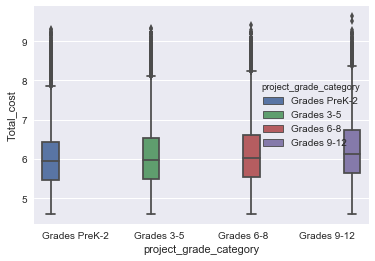

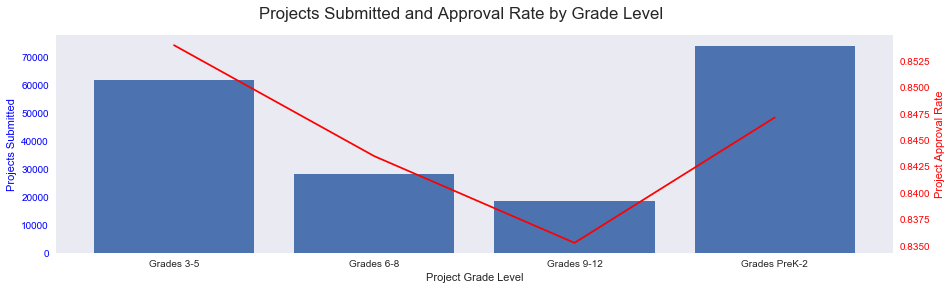

In [31]:
##boxplot quantity by is_approved
sns.boxplot(x="project_grade_category", 
            y=df_train["Total_cost"].apply(np.log),
            hue="project_grade_category",
 data=df_train)

projGrade = df_train.pivot_table(values=['proj_submitted_count','project_is_approved'],
                                        index='project_grade_category',
                                        aggfunc={'proj_submitted_count' : np.sum
                                               , 'project_is_approved' : np.sum})
projGrade.reset_index(level=0, inplace = True)

projGrade['proj_approval_rate'] = (projGrade.project_is_approved/projGrade.proj_submitted_count)
del projGrade['project_is_approved']

grade = projGrade.project_grade_category  
projSubmitted = projGrade.proj_submitted_count
projApprvdRate = projGrade.proj_approval_rate

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()
fig.set_figwidth(15)
fig.suptitle('Projects Submitted and Approval Rate by Grade Level')

#Plot bars
#projSubmitted.plot()
plt.bar(grade,projSubmitted)
ax1.set_xlabel('Project Grade Level')
ax1.grid(False)

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Projects Submitted', color='b')
[tl.set_color('b') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
plt.plot(grade,projApprvdRate, color = 'red')
ax2.grid(False)

# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Project Approval Rate', color='r')
[tl.set_color('r') for tl in ax2.get_yticklabels()]
plt.show()

The chart directly above shows projects submitted and approval rates by grade level.  Note that the highest number of submissions comes from grades pre-kindergarten through second - while the highest approval rates are for grades three through five.  The higher approval rates for grades three through five may be caused by a 'Goldilocks' effect, where donors and also reviewers of the applications subconsciously conclude that children of this age are 'just right' for learning (but also still cute little kids).  Intuitively, people may often think of this as a golden age of childhood development and therefore be more willing to approve an application and donate towards their needs.

Total cost, however, may be a confounding factor when analyzing approval rates by grade.  It would not be unreasonable to posit that smaller chilren require less expensive resources in their education - and that it is actually the lower cost of materials that drives the higher approval rates (recall from earlier that cost and approval rates appeared to be negatively correlated).

In the final analysis for this section we will consider approval rates by the number of projects previously submitted.

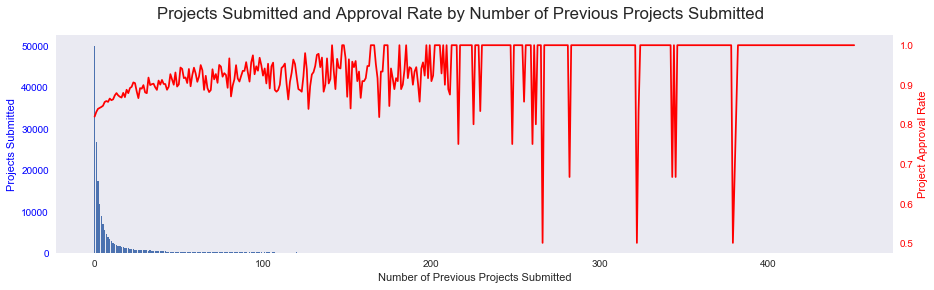

In [32]:
projPrev = df_train.pivot_table(values=['proj_submitted_count','project_is_approved'],
                                        index='teacher_number_of_previously_posted_projects',
                                        aggfunc={'proj_submitted_count' : np.sum
                                               , 'project_is_approved' : np.sum})
projPrev.reset_index(level=0, inplace = True)

projPrev['proj_approval_rate'] = (projPrev.project_is_approved/projPrev.proj_submitted_count)
del projPrev['project_is_approved']

prev = projPrev.teacher_number_of_previously_posted_projects  
#print(state)
projSubmitted = projPrev.proj_submitted_count
#print(projSubmitted)
projApprvdRate = projPrev.proj_approval_rate
#print(projApprvdRate)

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()
fig.set_figwidth(15)
fig.suptitle('Projects Submitted and Approval Rate by Number of Previous Projects Submitted')

#Plot bars
#projSubmitted.plot()
plt.bar(prev,projSubmitted)
ax1.set_xlabel('Number of Previous Projects Submitted')
ax1.grid(False)

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Projects Submitted', color='b')
[tl.set_color('b') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
plt.plot(prev,projApprvdRate, color = 'red')
ax2.grid(False)

# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Project Approval Rate', color='r')
[tl.set_color('r') for tl in ax2.get_yticklabels()]
plt.show()

The chart above shows projects submitted and approval rates by number of previous projects submitted.  Approval rates increase as teachers gain more experience with the application process.  This is not surprising, but was included in this analysis to display the extreme right skew for this variable.  As with the correlations between quantity and total cost, this will be examined more closely in the next section.

### Summary

Some important insights have been gained from this analysis.  Overall approval rates are high, and the chances of an application being approved are increased for those who request lower quantities and lower total costs in their applications.  Furthermore, teachers of lower grade levels have a better possibility of having their applications accepted when compared to teachers in the upper grade levels.  Volume of total applications submitted also increases the likelihood of acceptance.  Timing may also be a factor for approval, although a data set that contained a longer time period would be helpful to perform further analysis for this.  Finally, teachers in certain states seem to have better overall odds of application acceptance.  As mentioned earlier, it would be interesting to overlay additional socio-economic attributes to see if this can help to add more insight into the differences amongst states.

## Explore Joint Attributes

In this section we will further examine the relationships between attributes that was begun in the Data Visualization section.

Let's take a look at the continuous variables in a scatter matrix to get a first look at the relationships between them.

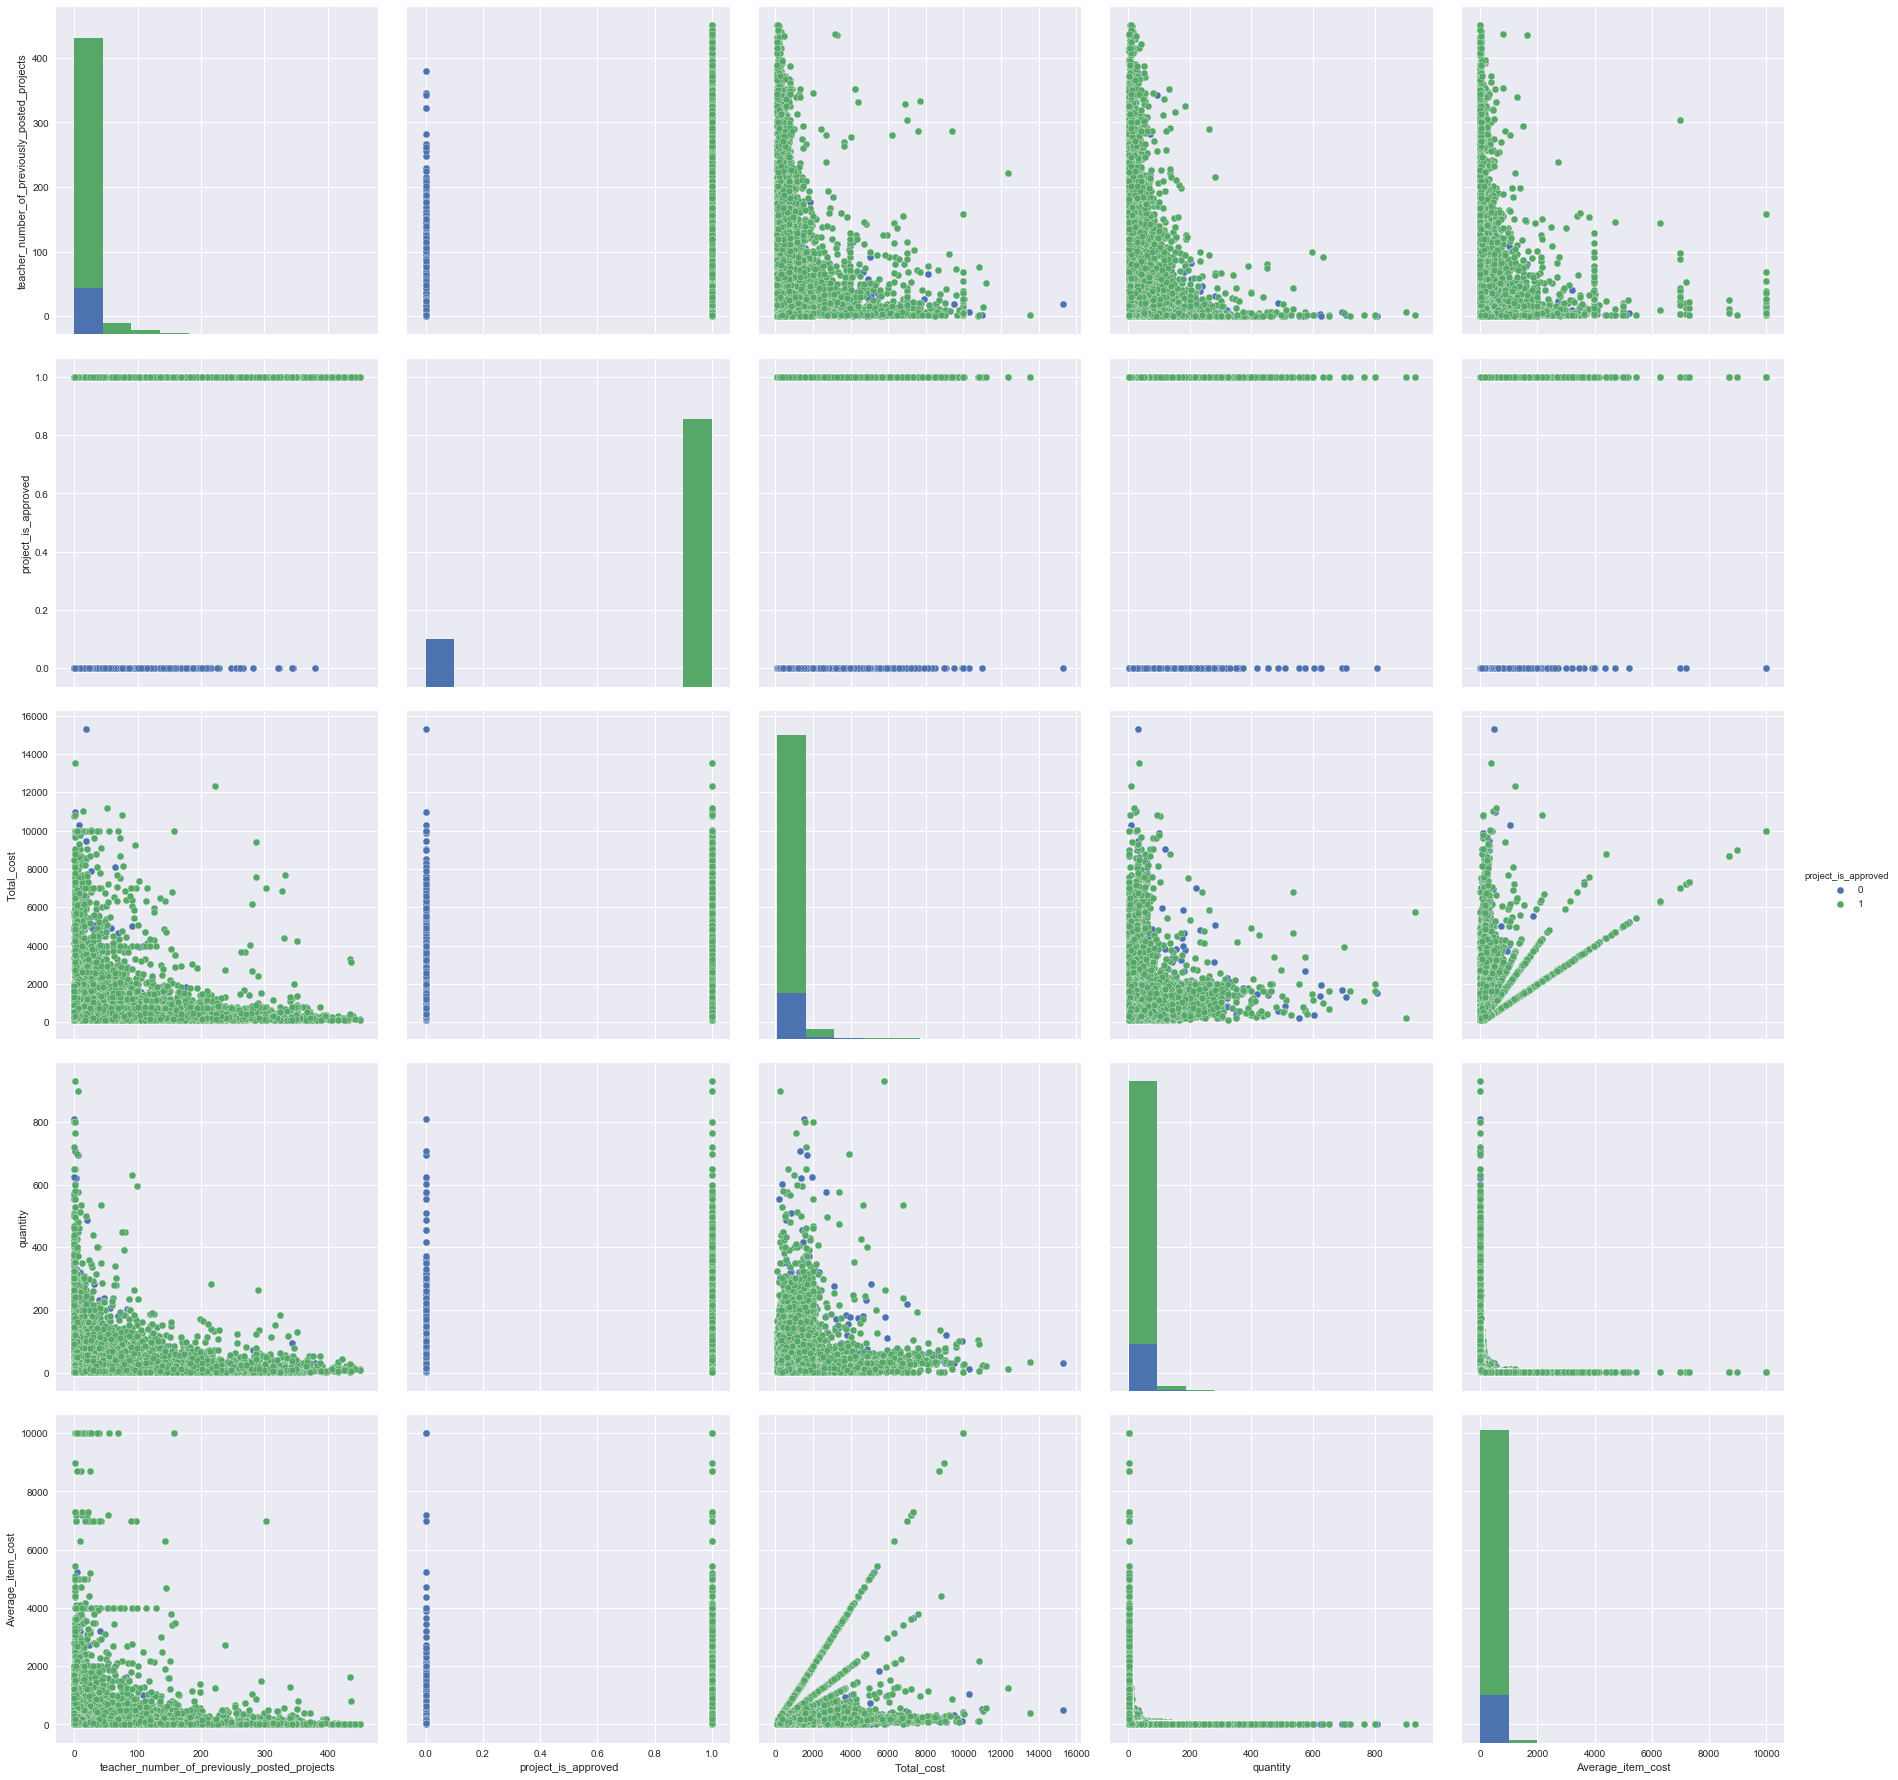

In [33]:
#first delete custom vars made only for visualization
del df_train['proj_submitted_count'] 
del df_train['project_submitted_datetime']
del df_train['project_submitted_YM']
del df_train['total_quantity_group']
del df_train['total_cost_group']

sns.pairplot(df_train,hue="project_is_approved", diag_kind = 'hist', size=5)
plt.show()

The first detail we'll pay attention to is what appears to be an extreme right skew for quantity, total cost, and the number of previously submitted projects. This can be seen along the diagonal of the scatter plot above. Since all of these attributes have the same general skew, the plots between variables exibits a similar skew.

Let's take a closer look at quantity and total cost.

In [34]:
sns.distplot(df_train["Total_Cost"].dropna(), bins=5, kde=True, color = 'green')
sns.distplot(df_train["True_Quantity"].dropna(), bins=5, kde=True)
plt.title('Kernal Density Estimation of Total Cost and Quantity')
plt.show()

KeyError: 'Total_Cost'

The chart above shows quantity and total cost (green line) in a kernal density plot. The right skew is so extreme that it is difficult to differentiate between the two.

In [35]:
df_train["Total_Cost"].apply(np.log).hist(color='green')
df_train["True_Quantity"].apply(np.log).hist()
plt.title('Log Transform of Total Cost and Quantity')
plt.show()

KeyError: 'Total_Cost'

The histogram above shows the same two attributes, quantity and total cost - but with a log transform. The log transform seems to greatly improve the distributions of the histogram. They both appear fairly normal now and it is easy to differentiate between the two.

Let's do the same analysis for previously submitted projects.

/Users/davidstroud/anaconda3/envs/snakes/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


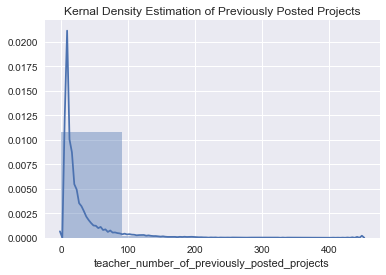

In [36]:
sns.distplot(df_train["teacher_number_of_previously_posted_projects"], bins=5, kde=True)
plt.title('Kernal Density Estimation of Previously Posted Projects')
plt.show()

The above kernal density plot for number of previously posted projects exihits a similar skew as was seen for quantity and total cost. Again, we will perform a log transform on this attribute to see if this helps to normalize the distributions.

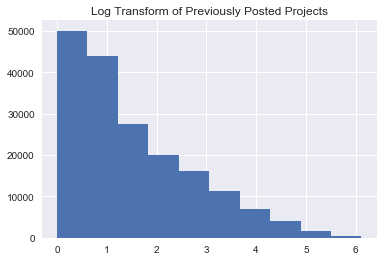

In [37]:
number = df_train["teacher_number_of_previously_posted_projects"]+1
number.apply(np.log).hist()
plt.title('Log Transform of Previously Posted Projects')
plt.show()

The histogram above uses a log transform to give a better visualization of the distribution of previously posted projects. Although the distribution is still not normal, we are still able to get a better idea of the overall distributions and looks similar to the histogram we saw in the simple statistics section where the prvevious posted projects was limited to <21.

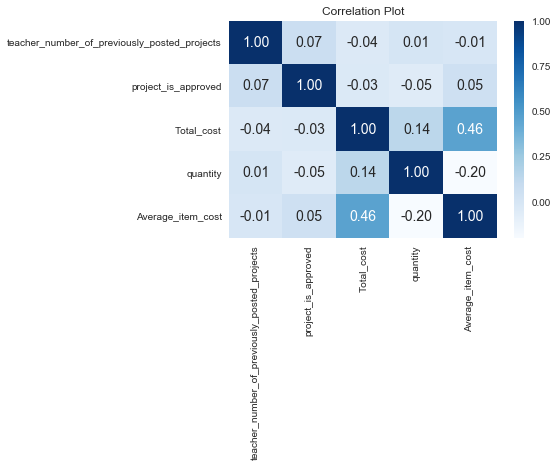

In [38]:
sns.heatmap(df_train.corr(), annot=True, fmt=".2f", cmap = 'Blues')
plt.title('Correlation Plot')
plt.show()

The chart above is a correlation plot for the discrete and continuous variables in our data set.

From this we see that the highest correlation is of total cost to average cost. This is trivial as average cost is a linear combination of total cost. The second highest correlation is between average cost and quantity. This is a negative correlation and is as we expected from our previuos analysis. The third highest correlation is between previosly posted projects and project is approved. This is a positive correlation and is also expected from our earlier analysis.

Although the correlations show what we expected to see in terms of polarity, it is important to note that none of the non-trivial relationships show a particularly strong correlation quantitatively.

#### Summary
Some important insights have been gained from this analysis. Overall approval rates are high, and the chances of an application being approved are increased for those who request lower quantities and lower total costs in their applications. The volume of total applications submitted also increases the likelyhood of acceptance. Timing may also be a factor for approval, although a data set that contained a longer time period would be helpful to perform further analysis for this. Teachers in certain states seem to have better overall odds of application acceptance. As mentioned earlier, it would be interesting to overlay additional socio-economic attributes to see if this can help to add more insight into the differences amongst states. Finally, although these relationships are better understood, the weak overall correlation and extreme skew of the explanatory variables will most likely make the overall prediction of approval or denial more difficult and data transformations such as log transforms will need to be applied.

### Explore Attributes and Class

What stood out the most was one of the questions that DonorsChoose tasked the data science community with, “How to increase the consistency of project vetting across different volunteers to improve the experience for teachers?” The project approval range is approximately 6% over a period of 13 months, so we do see variation that gives us an indication that there is inconsistency in their approval process. It would be helpful to know more about their approval process. How long does it take? Are there random assignments to projects? Is there a potential for lag time between submission and approval? Could we measure success if the approval range of 6% were reduced?

For further analysis, it would be interesting to see what percentage of the approved states have Title I assistance from the US Department of Education. It is not explicitly collected in this data, but after reviewing a few requests from teachers on DonorsChoose’s website, it is often mentioned in teachers' proposals. Perhaps this is something that our analysis will be able to determine. The summary portion of our visualization mentions a desire to overlay additional socio-economic attributes to add insight to the approval process. As our model will be using Natural Language Processing for different types of analysis, discovering text that specifically mentions Title I in their requests has the potential to uncover patterns that determine whether of not a project will be approved. 

## New Features

We have already added several new features to the dataset, including total project cost, quantity of items requested, and average cost of items requested.

Two features in the data set, Subject Category and Subject Subcategory, can contain multiple values. In order to accurately use the Category feature, we created new boolean features to indicate whether a project was classified in each of the eight possible categories. 

In [39]:
df_train["lsLangLit"]=df_train["project_subject_categories"].str.contains("Literacy & Language")
df_train["lsMathSci"]=df_train["project_subject_categories"].str.contains("Math & Science")
df_train["lsAppLearn"]=df_train["project_subject_categories"].str.contains("Applied Learning")
df_train["lsHealth"]=df_train["project_subject_categories"].str.contains("Health & Sports")
df_train["lsSpNeeds"]=df_train["project_subject_categories"].str.contains("Special Needs")
df_train["lsHistCiv"]=df_train["project_subject_categories"].str.contains("History & Civics")
df_train["lsMusArts"]=df_train["project_subject_categories"].str.contains("Music & The Arts")
df_train["lsWarm"]=df_train["project_subject_categories"].str.contains("Warmth, Care & Hunger")

If during the next phase of analysis, we determine that Subject Category is a significant predictor, we may need to continue to add additional features in the same way for the Subcategories. 

With respect to features that are not in the dataset, there are a few that would be helpful in predicting project approval. The most important would be the number of FARM (Free and Reduced [Price] Meals) students in the school. This would be important because a DonorsChoose is a charity and would likely focus on underprivileged students. Indeed, looking at DonorsChoose projects posted currently, they do provide an estimate the proportion of FARM students in the classroom being benefited. Unfortunately, that information is missing in the dataset we are using.

Another helpful feature would be the number of students that would benefit from the project being funded. Is the project for a class set for a single teacher, or a class set that will be shared among 3 teachers? Earlier examination of some projects revealed that they were to benefit students of an entire school, not just single classrooms. Schools and classrooms can be of different sizes as well, so estimates for the number of students benefiting from a project would be a great piece of information. While the dataset used does not have this information, current DonorsChoose projects in fact display it.

## Exceptional Work

### Using the NLTK library and Natural Language Processing with Python 

Natural Language Processing (NLP) is a field of study focused on making sense of language using statistics and computers. One of the goals of NLP is to extract meaning and learn from text data. This type of analysis bodes well with the DonorsChoose project, as we have six text variables that need to be analyzed as part of our model. NLP offers an attractive opportunity to put the text into a format that is statistically useful for our model; i.e., is the text positive, neutral, or negative. What separates the six variables that we will be using with NLP is that they are not classified as categorical or continuous. This is where Natural Language Processing and the NLTK library can assist our team in making sure that our data is in a format that will offer a model the best opportunity to evaluate the predicted probability and the observed target. 

NLP has the ability to increase the consistency of project vetting across different volunteers. One could make the argument that the text variables present the most ambiguity among all of the different variables, making it substantially more difficult to factor into our analysis. NLP would bring uniformity, consistency, and a more scientific approach to vetting the text portion of the proposal requests. 

### The DonorsChoose project has six variables that are text based.
-  project_title
-  project_essay_1
-  project_essay_2
-  project_essay_3
-  project_essay_4
-  project_resource_summary

### Introducting the NLTK library for Natural Language Processing
The NLTK library provides a platform in Python to work with human language data and use a suite of text processing libraries for classification, tokenization, semantic reasoning, and several NLP tools. Our purpose of using NLP in this project it to classify text according to intent. In other words, how urgent is the request, do the basic needs of the teacher match up with grants that have been approved in the past? 

In [40]:
import nltk # Library used for computational linguistics and natural languages in Python
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/davidstroud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/davidstroud/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/davidstroud/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/davidstroud/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

### Data Cleaning
It is paramount to interpret and understand our models to ensure that we are actually capturing information and not noise. We will use tokenization, removal of irrelevant or misspelled words, and convert all characters to lower case to treat works such as "Donor", "DONOR", and "donor" the same. 

A key concept to understanding NLP is tokenization, which is simply turning a string or document into tokens (smaller chunks). This is one step in preparing a text for NLP. You can create your own rules using regular expressions.  

### Some examples and uses of Tokenization:
-  Breaking out words or sentences
-  Separating punctuation
-  Separating all hashtags in a tweet 
-  Easier to map part of speech
-  Matching common words
-  Removing unwanted tokens

In [41]:
'''Title: A Very Extensive End to End Project: DonorsChoose
    Author: Lathwal
    Date: 2018
    Code version: 1.0
    Availability: https://www.kaggle.com/codename007/a-very-extensive-end-to-end-project-donorschoose/notebook
'''

import re
from nltk.corpus import stopwords
nltk.download('stopwords')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()# lowercase text  
    text = REPLACE_BY_SPACE_RE.sub(' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text    
    text = BAD_SYMBOLS_RE.sub('',text)# delete symbols which are in BAD_SYMBOLS_RE from text    
    temp = [s.strip() for s in text.split() if s not in STOPWORDS]# delete stopwords from text
    new_text = ''
    for i in temp:
        new_text +=i+' '
    text = new_text
    return text.strip()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidstroud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### WordCloud

Lets turn our attention to WordCloud analysis. The visualization below takes the project_resource_summary variable and extracts keywords from that particular variable.  The larger the keyword, the more often it appears in the project_resource_attribute. This gives us a sense of what keywords are being requested the most. The visualization could be used as confirmation of other attributes from previous analysis, as well as provide a portal into more advanced NLP analysis that attempt to determine sentiment.

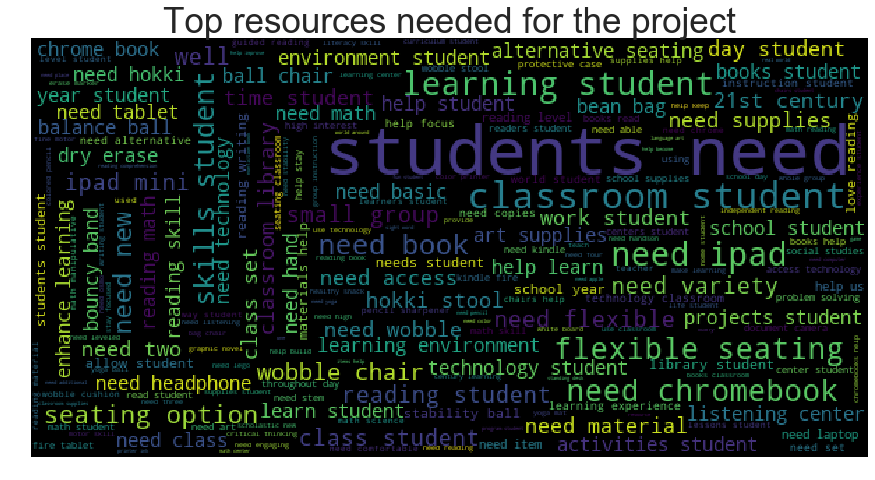

In [42]:
'''Title: A Very Extensive End to End Project: DonorsChoose
    Author: Lathwal
    Date: 2018
    Code version: 1.0
    Availability: https://www.kaggle.com/codename007/a-very-extensive-end-to-end-project-donorschoose/notebook
'''

temp_data = df_train.dropna(subset=['project_resource_summary'])
# converting into lowercase
temp_data['project_resource_summary'] = temp_data['project_resource_summary'].apply(lambda x: " ".join(x.lower() for x in x.split()))
temp_data['project_resource_summary'] = temp_data['project_resource_summary'].map(text_prepare)


from wordcloud import WordCloud # https://github.com/amueller/word_cloud

wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(temp_data['project_resource_summary'].values))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("Top resources needed for the project", fontsize=35)
plt.axis("off")
plt.show() 